In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [16]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [4]:
# we need to bootstrap to know the error of N_UDG

In [5]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel.fits')
from sample_cuts import post_process_cat_new
cuts_cat = post_process_cat_new(input_cuts_cat)

In [6]:
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')

In [7]:
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220519.fits')
# fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.2]
density_bkg = len(fake_udg_cat) / (5 * 20) / 24 # bkg per sqr deg

In [8]:
len(cuts_cat)

2056

In [9]:
_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] > 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]

_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)

n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()

Total angular area [deg2]: 26.054865360768236


---

In [10]:
roman17b = [[11.858108108108109, 0.006651884700664468], 
            [12.015202702702704, 0.4789356984478932], 
            [12.85641891891892, 0.30598669623059793]]
roman17b_xerr = [[-0.43, 0.23], 
                 [0, 0], 
                 [-1.14, 0.284]]
roman17b_yerr = [[-0.399, 0.29], 
                 [-0.359, 0.206], 
                 [-0.55, 0.239]]


roman17a = [[13.16554054054054, 1.0177383592017737],
            [14.244932432432432, 1.5432372505543237]]
roman17a_xerr = [[-0.294, 0.183], 
                 [-0.28, 0.15]]
roman17a_yerr = [[-0.14, 0.14], 
                 [-0.20, 0.206]]

koda = [14.91891891891892, 2.3082039911308208]
koda_xerr = 0.08
koda_yerr = 0.1

Janssens = [[15.679054054054053, 3.33259423503326]]
Janssens_xerr = [[-0.375, 0.2]]
Janssens_yerr = [[-0.13, 0.12]]

Munoz = [14.047297297297298, 1.4501108647450112]
Munoz_xerr = 0.10
Munoz_yerr = 0.13

Total angular area [deg2]: 31.583616757093672
Total angular area [deg2]: 26.054865360768236
Total angular area [deg2]: 5.528751396325437
Total angular area [deg2]: 5.6840436978174
Total angular area [deg2]: 4.805927363924537


Text(0, 0.5, '$\\log\\, N_{\\rm UDG}$')

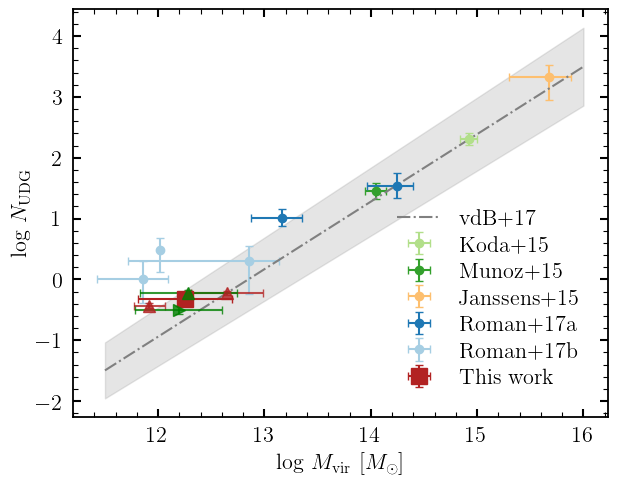

In [77]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fdbf6f']#['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']


plt.errorbar(*koda,
             xerr=koda_xerr,
             yerr=koda_yerr,
             fmt='o', label='Koda+15', color=colors[2])

plt.errorbar(*Munoz,
             xerr=np.array(Munoz_xerr),
             yerr=Munoz_yerr,
             fmt='o', label='Munoz+15', color=colors[3])

plt.errorbar(np.array(Janssens)[:, 0], np.array(Janssens)[:, 1], 
             xerr=np.abs(np.array(Janssens_xerr)).T,
             yerr=np.abs(np.array(Janssens_xerr)).T,
             fmt='o', label='Janssens+15', color=colors[4])


plt.errorbar(np.array(roman17a)[:, 0], np.array(roman17a)[:, 1], 
             xerr=np.abs(np.array(roman17a_xerr)).T,
             yerr=np.abs(np.array(roman17a_yerr)).T,
             fmt='o', label='Roman+17a', color=colors[1])

plt.errorbar(np.array(roman17b)[:, 0], np.array(roman17b)[:, 1], 
             xerr=np.abs(np.array(roman17b_xerr)).T,
             yerr=np.abs(np.array(roman17b_yerr)).T,
             fmt='o', label='Roman+17b', color=colors[0])


x = np.linspace(11.5, 16, 10)

plt.plot(x, 1.11 * x + np.log10(19) - 1.11 * 14, label='vdB+17', ls='-.', color='gray')

plt.fill_between(x, (1.11 + 0.04) * x + np.log10(19) - 1.11 * 14, 
                 (1.11 - 0.04) * x + np.log10(19) - 1.11 * 14, 
                 alpha=0.2, color='gray', interpolate=True)

##### Total sample #####
_cuts_cat = cuts_cat
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10([n_udg]), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='s', ms=12, color='firebrick', label='This work',)

##### Mass bins #####
_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] > 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, color='firebrick', alpha=0.8)

_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] < 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, color='firebrick', alpha=0.8)


_cuts_cat = cuts_cat[cuts_cat['host_elliptical'].data.data == 1]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, color='green', alpha=0.8)


_cuts_cat = cuts_cat[cuts_cat['host_spiral'].data.data == 1]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='>', ms=8, color='green', alpha=0.8)

plt.legend()
plt.xlabel(r'$\log\, M_{\rm vir}\ [M_\odot]$')
plt.ylabel(r'$\log\, N_{\rm UDG}$')

---
### Divide hosts into early and late type

Total angular area [deg2]: 31.583616757093672
Total angular area [deg2]: 26.054865360768236
Total angular area [deg2]: 5.528751396325437
Total angular area [deg2]: 5.6840436978174
Total angular area [deg2]: 4.805927363924537


Text(0, 0.5, '$\\log\\, N_{\\rm UDG}$')

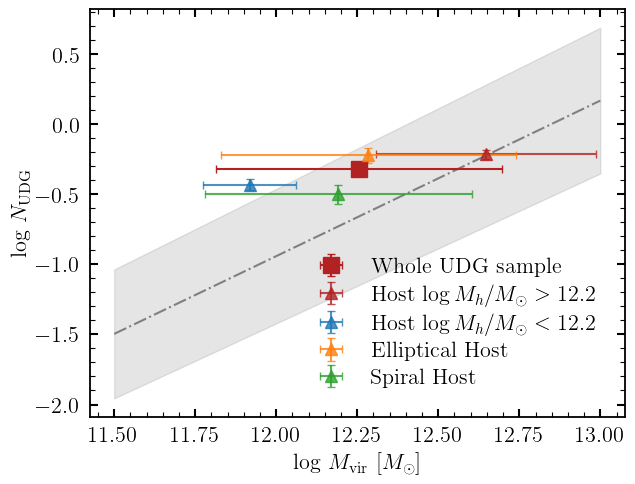

In [89]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

x = np.linspace(11.5, 13, 10)

plt.plot(x, 1.11 * x + np.log10(19) - 1.11 * 14, ls='-.', color='gray')

plt.fill_between(x, (1.11 + 0.04) * x + np.log10(19) - 1.11 * 14, 
                 (1.11 - 0.04) * x + np.log10(19) - 1.11 * 14, 
                 alpha=0.2, color='gray', interpolate=True)

##### Total sample #####
_cuts_cat = cuts_cat
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10([n_udg]), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='s', ms=12, color='firebrick', label='Whole UDG sample')

##### Mass bin 1 #####
_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] > 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, color='firebrick', alpha=0.8, label=r'Host $\log M_h/M_\odot > 12.2$')

##### Mass bin 2 #####
_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] < 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, alpha=0.8, label=r'Host $\log M_h/M_\odot < 12.2$')

##### ETG host #####
_cuts_cat = cuts_cat[cuts_cat['host_elliptical'].data.data == 1]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, alpha=0.8, label=r'Elliptical Host')


_cuts_cat = cuts_cat[cuts_cat['host_spiral'].data.data == 1]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='^', ms=8, alpha=0.8, label=r'Spiral Host')

plt.legend()
plt.xlabel(r'$\log\, M_{\rm vir}\ [M_\odot]$')
plt.ylabel(r'$\log\, N_{\rm UDG}$')

In [63]:
np.sqrt((len(_udg_cat) - density_bkg * total_area)) / (len(_udg_cat) - density_bkg * total_area)

0.08849840348020213

In [12]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220519.fits')
# fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.2]
density_bkg = len(fake_udg_cat) / (5 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 31.583616757093672


In [13]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)

n_udg = (len(udg_cat) - density_bkg * total_area) / len(np.unique(cuts_cat['host_name']))
m_vir = np.unique(cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(cuts_cat['host_halo_mass']).std()

Total angular area [deg2]: 31.583616757093672


---

In [15]:
vdb17_x = np.array([12.23, 12.62, 13.03, 13.36, 13.77, 14.04, 14.52])
vdb17_y = np.array([-0.21, 0.32, 1.38, 3.31, 7.54, 44.93, 64.29])
vdb17_yerr = np.array([[-0.61, -0.93, -1.04, -1.62, -3.97, -38.98, -15.92], 
                       [0.52, 1.08, 1.26, 1.51, 5.22, 21.54, 18.16]])

vdb17_yerr_stat = np.array([[-0.45, -0.55, -0.49, -0.78, -2.21, -12.23, -15.92], 
                             [0.51, 0.62, 0.56, 0.89, 2.52, 13.95, 18.16]])

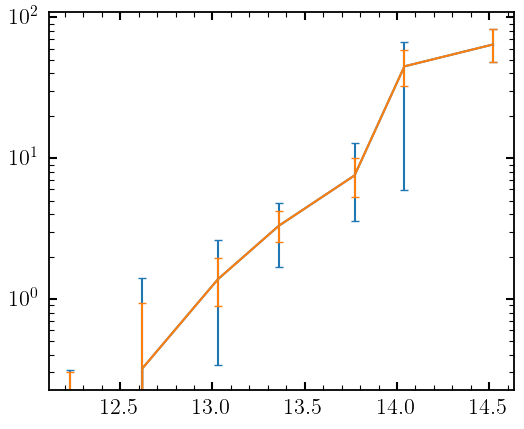

In [393]:
plt.errorbar(vdb17_x, vdb17_y, yerr=np.abs(vdb17_yerr))
plt.errorbar(vdb17_x, vdb17_y, yerr=np.abs(vdb17_yerr_stat))
plt.yscale('log')

In [396]:
x = vdb17_x
y = vdb17_y
yerr = np.max(np.abs(vdb17_yerr_stat), axis=0)

In [397]:
import numpy as np
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def model(x, y=None, yerr=0.1):
    a = numpyro.sample('a', dist.Uniform(-10, 10))
    b = numpyro.sample('b', dist.Uniform(-50, 0))
    y_ = 10**(b + a * x)
    # notice that we clamp the outcome of this sampling to the observation y 
    numpyro.sample('obs', dist.Normal(y_, yerr), obs=y)
    
# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# run HMC with NUTS
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, x=x, y=y, yerr=yerr)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:04<00:00, 837.14it/s, 1 steps of size 7.43e-02. acc. prob=0.01] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.56      0.58      1.59      1.59      1.72    123.05      1.01
         b    -21.48      1.41    -21.18    -23.02    -21.18    215.10      1.02

Number of divergences: 2832
